# The Effectiveness of Edge Detection Evaluation Metrics for Automated Coastline Detection
<br>
Conor O'Sullivan 
<br>
27 Feb 2023

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import glob
from skimage import feature

from skimage.metrics import structural_similarity as ssim
from sewar.full_ref import rmse, psnr, uqi

# Import helper functions from utils.py
import utils 

#Save path 
save_path = '~/Google Drive/My Drive/UCD/research/Evaluation metrics/'


In [90]:
# Reload utils
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/conorosullivan/Documents/git/COASTAL MONITORING/edge-detection-metrics/src/utils.py'>

## Load images and edge reference

In [2]:
test_path = glob.glob("../../data/SWED/test/images/*")
print(test_path[0])
print(len(test_path))

# Load all images and labels
input = []
rgb = []
labels = []

for path in test_path:
    try:
        img, rgb_img, label = utils.load_test(path)
    
        input.append(img)
        labels.append(label)
        rgb.append(rgb_img)
    except:
        print("Error with image: ", path)

# Apply canny edge detection to binary maps to get reference edges
canny_input = [np.uint8(img*255) for img in labels]
edge_reference = [np.uint8(cv2.Canny(img,threshold1 = 100, threshold2 = 200)) for img in canny_input]

../../data/SWED/test/images/S2A_MSIL2A_20191105T023901_N0213_R089_T50RPN_20191105T062756_image_0_0.tif
98


0 255


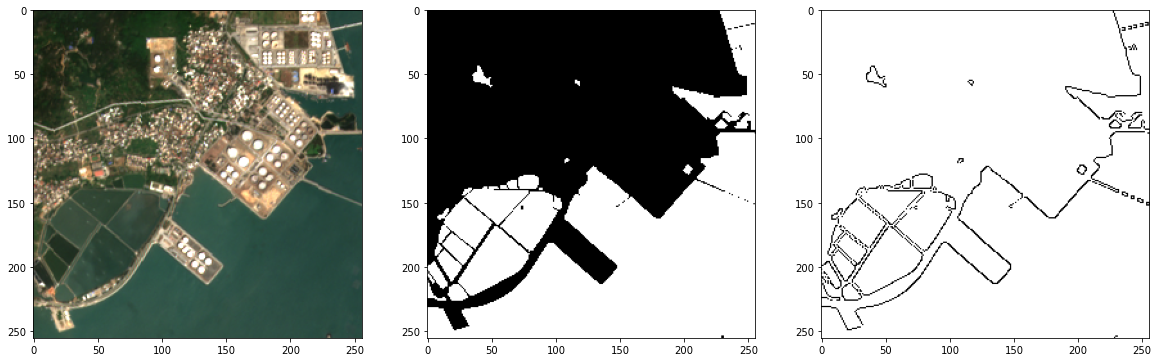

In [3]:
# Sense check edge references
rint = np.random.randint(0,len(edge_reference))

fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(rgb[rint])
ax[1].imshow(labels[rint], cmap='gray')
ax[2].imshow(255-edge_reference[rint], cmap='gray')

print(np.min(edge_reference[rint]) ,np.max(edge_reference[rint]))

## Apply canny edge detection and evaluation metrics

In [8]:
# Apply canny edge detection with different intensity thresholds
#thresholds = [[50,100],[50,150],[100,200],[100,300],[200,400],[200,600]]
thresholds = [[10,20],[20,40],[50,100],[100,200],[200,400]]

canny_input = input.copy()
canny = {}

for threshold in thresholds:
        t1 = threshold[0]
        t2 = threshold[1]
        canny[str(threshold)] = [utils.canny_ed(img,threshold1=t1,threshold2=t2) for img in canny_input]

        print(threshold, len(canny[str(threshold)]),'done')

[10, 20] 98 done
[20, 40] 98 done
[50, 100] 98 done
[100, 200] 98 done
[200, 400] 98 done


In [9]:
# Evaluate canny edge detection with rmse, psnr, uqi, ssim and fom
rows = []

for threshold in thresholds:
    canny_output = canny[str(threshold)]

    for i, output in enumerate(canny_output):
        ref_img = edge_reference[i]
        ID = "IMG#{}".format(i)

        #for j in range(len(utils.channels)):
        for j in [1,7]:
                
            img = output[:,:,j]

            # Evaluation metrics
            rmse_ = rmse(ref_img,img)
            psnr_ = psnr(ref_img,img)
            uqi_ = uqi(ref_img,img)
            ssim_ = ssim(ref_img,img,multichannel=True)
            fom_ = utils.fom(ref_img,img)
            
            row = [ID,str(threshold),j+ 1,rmse_,psnr_,uqi_,ssim_,fom_]
            rows.append(row)

    print(threshold,'done')

    
df_metrics = pd.DataFrame(rows,columns = ['ID',"thresholds","band","rmse","psnr","uqi","ssim","fom"])
#df_metrics.to_csv(save_path+"canny_evaluation_metrics.csv")
df_metrics.to_csv(save_path+"canny_evaluation_metrics_test.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_44294/930212767.py:20: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)


[10, 20] done
[20, 40] done
[50, 100] done
[100, 200] done
[200, 400] done


,ID,thresholds,band,rmse,psnr,uqi,ssim,fom
0,IMG#0,"[10, 20]",2,120.925945,6.480414,0.240874,0.358314,0.188619
1,IMG#0,"[10, 20]",8,123.660135,6.286209,0.293419,0.362096,0.203235
2,IMG#1,"[10, 20]",2,70.053086,11.222258,0.745008,0.778468,0.260180
3,IMG#1,"[10, 20]",8,67.064559,11.600942,0.773702,0.795571,0.252069
4,IMG#2,"[10, 20]",2,140.703311,5.164717,0.011267,0.134543,0.039642


## Analyse metric trend

In [3]:
df_metrics = pd.read_csv(save_path+"canny_evaluation_metrics.csv")
df_metrics.head()

,Unnamed: 0,ID,thresholds,band,rmse,psnr,uqi,ssim,fom
0,0,IMG#0,"[50, 100]",1,122.943958,6.336660,0.047913,0.180501,0.196401
1,1,IMG#0,"[50, 100]",2,155.470420,4.297848,0.030854,0.044116,0.184739
2,2,IMG#0,"[50, 100]",3,154.600040,4.346612,0.029501,0.042279,0.185332
3,3,IMG#0,"[50, 100]",4,153.834417,4.389733,0.031009,0.052277,0.185448
4,4,IMG#0,"[50, 100]",5,135.333184,5.502718,0.028982,0.114205,0.184649


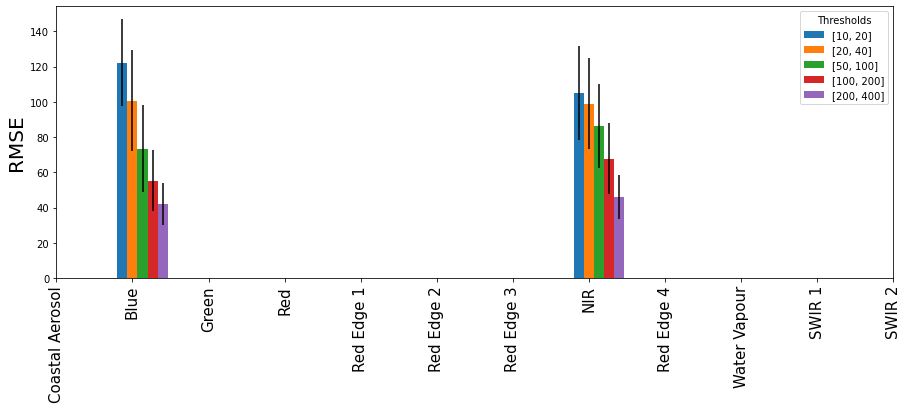

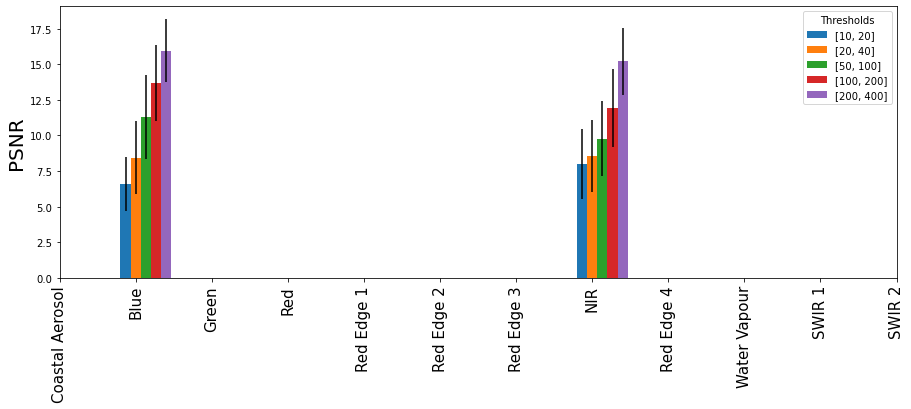

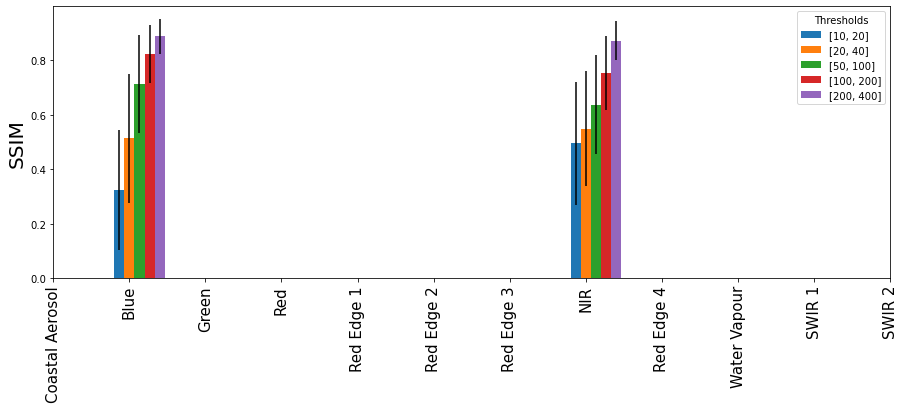

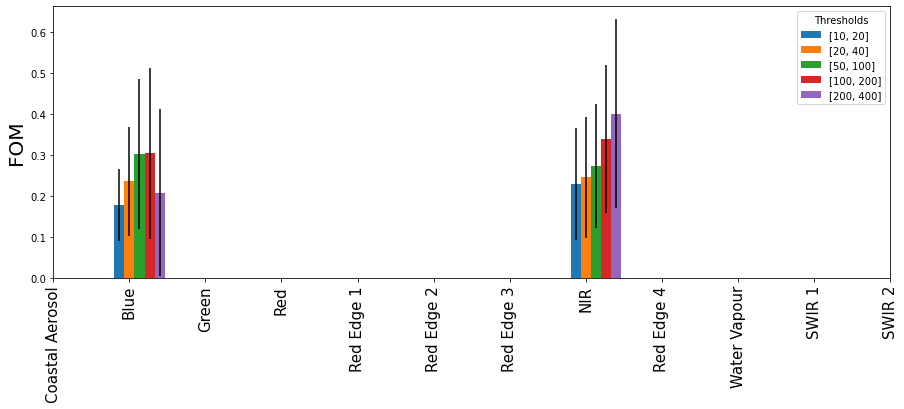

In [10]:
utils.plot_metric_trends(df_metrics,'rmse')
utils.plot_metric_trends(df_metrics,'psnr')
#utils.plot_metric_trends(df_metrics,'uqi')
utils.plot_metric_trends(df_metrics,'ssim')
utils.plot_metric_trends(df_metrics,'fom')


In [ ]:
## Example images 


In [ ]:
## FOM alpha parameter

In [7]:
def channel_filter(img,c=0):
    """Returns given channel from image"""
    img = np.array(img)
    c_img = img[:, :, c]

    return c_img


def plot_channels(img,invert=False):
    
    """Plot all channels of a given image"""
    
    global channels

    fig, axs = plt.subplots(3,4,figsize=(15,10))

    index = 0
    for i in range(3):
        for j in range(4):
            c_img = channel_filter(img,c=index)
            if invert:
                c_img = 255-c_img

            axs[i,j].imshow(c_img,cmap='gray')
            axs[i,j].set_title(channels[index])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

            index +=1

def preprocess(img_input, toggle=[True,True,False]):
        """Preprocess image for edge detection
        toggle: [Equalized histogram, Gaussian blur, Morphological closing]
        """
        img = img_input.copy()
        img = np.array(img)

        # Iterate over bands
        for i in range(12):
                img_i = img[:,:,i]

                # Scale bands between 0 and 255
                img[:,:,i] = cv2.normalize(img[:,:,i], None, 0, 255, cv2.NORM_MINMAX)

                # Equalized histogram
                img_i = np.uint8(img_i)
                if toggle[0]:
                        img_i = cv2.equalizeHist(img_i)


                # Gaussian blur
                if toggle[1]:
                        kernel = (5, 5)
                        img_i = cv2.GaussianBlur(img_i, kernel,0)

                # Morphological closing
                if toggle[2]:
                        kernel = np.ones((5,5),np.uint8)
                        img_i = cv2.morphologyEx(img_i, cv2.MORPH_CLOSE, kernel)
                
                img[:,:,i] = img_i
       
        img = np.uint8(img)
        return img
def canny_ed(img_input, threshold1=100, threshold2=200):

    """Apply canny edge detection to image"""
    
    img = img_input.copy()
    img = np.array(img)
    img = np.uint8(img)

    # Iterate over bands
    for i in range(12):
        img_i = img[:,:,i]

        #kernel = (5, 5)
        #img_i = cv2.GaussianBlur(img_i, kernel,0)

        #img_i = cv2.normalize(img_i, None, 0, 255, cv2.NORM_MINMAX)
        
        img_i = cv2.Canny(img_i,threshold1 = threshold1, threshold2 = threshold2)
        #img_i = feature.canny(img_i, sigma=2, low_threshold=threshold1, high_threshold=threshold2)


        img[:,:,i] = img_i

    return img

In [5]:
df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_canny.csv")

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_48585/378155489.py:31: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = round(ssim(ref_img,img,multichannel=True),2)


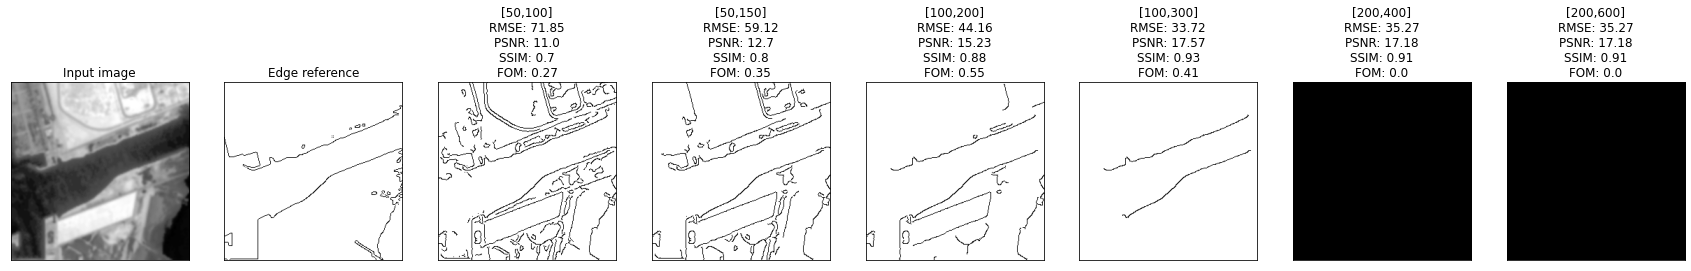

In [68]:
fig, axs = plt.subplots(1, 8, figsize=(30, 20))
fig.set_facecolor('white')
rint = np.random.randint(0, len(input))

band = 10 #blue

preprocess_input = input[rint].copy()
preprocess_input = preprocess(preprocess_input)

axs[0].imshow(preprocess_input[:,:,band],cmap="gray")
axs[0].set_title("Input image")

ref_img = edge_reference[rint]
axs[1].imshow(255-ref_img,cmap="gray")
axs[1].set_title("Edge reference")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

for i,threshold in enumerate(thresholds):
        
    t1 = threshold[0]
    t2 = threshold[1]
    canny = canny_ed(preprocess_input,threshold1=t1,threshold2=t2)
    img = canny[:,:,band]
    
    axs[i+2].imshow(255-img,cmap="gray")
    rmse_ = round(rmse(ref_img,img),2)
    psnr_ = round(psnr(ref_img,img),2)
    ssim_ = round(ssim(ref_img,img,multichannel=True),2)
    fom_ = round(fom(ref_img,img),2)
                
    axs[i+2].set_title("[{},{}]\nRMSE: {}\nPSNR: {}\nSSIM: {}\nFOM: {}".format(t1,t2,rmse_,psnr_,ssim_,fom_))

(256, 256)

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_48585/3587505056.py:18: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = round(ssim(ref_img,img,multichannel=True),2)


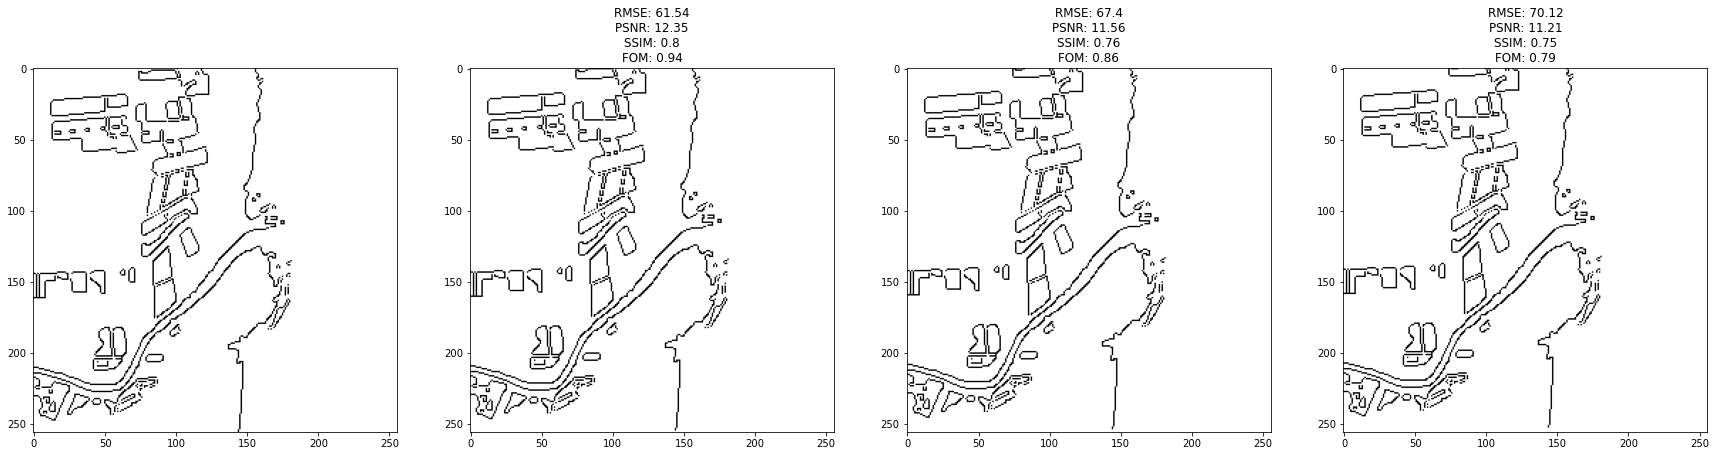

In [88]:
rint = np.random.randint(0, len(input))

band = 10 #blue
fig, axs = plt.subplots(1, 4, figsize=(30, 20))

ref_img = edge_reference[rint]
axs[0].imshow(255-ref_img,cmap="gray")

img = ref_img.copy()

for i in range(3):

    img = img[1:]
    img = np.vstack([img,[0]*256])

    rmse_ = round(rmse(ref_img,img),2)
    psnr_ = round(psnr(ref_img,img),2)
    ssim_ = round(ssim(ref_img,img,multichannel=True),2)
    fom_ = round(fom(ref_img,img),2)


    axs[i+1].imshow(255-img,cmap="gray")
    axs[i+1].set_title("RMSE: {}\nPSNR: {}\nSSIM: {}\nFOM: {}".format(rmse_,psnr_,ssim_,fom_))

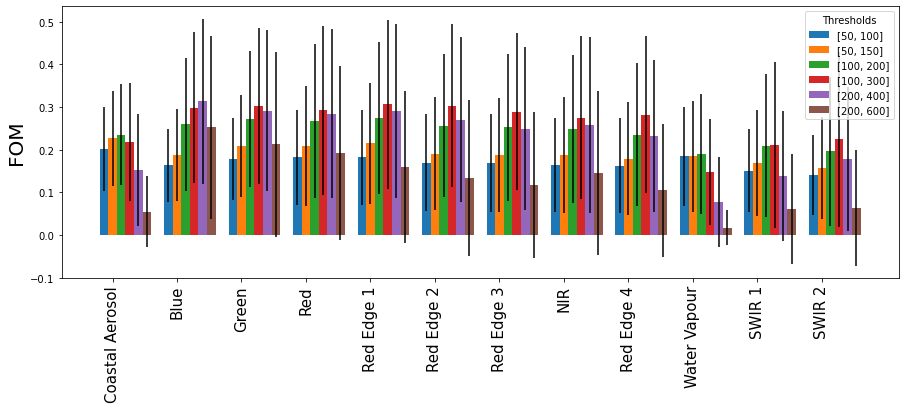

In [16]:
mean =  df_metrics[df_metrics.toggle=="[True, True, False]"].groupby(["thresholds","band"],as_index=False).mean()
sd =  df_metrics[df_metrics.toggle=="[True, True, False]"].groupby(["thresholds","band"],as_index=False).std()
metric = "fom"
global channels

thresholds = [[50,100],[50,150],[100,200],[100,300],[200,400],[200,600]]
toggles = [[True,False,False],[True,True,False],[True,False,True],[True,True,True]]

fig,ax = plt.subplots(1,1,figsize=(15,5))

w = 0.4
for i,thresh in enumerate(thresholds):

    bands = mean[mean.thresholds==str(thresh)]["band"]

    mean_i = mean[mean.thresholds==str(thresh)][metric]
    sd_i = sd[sd.thresholds==str(thresh)][metric]
    
    plt.bar(bands-w/3+i*w/3,mean_i,yerr=sd_i,width=w/3,label=str(thresh))

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

plt.legend(title="Thresholds")

# Figure for abstract

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_43944/2923106426.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = round(ssim(ref_img,img,multichannel=True),2)


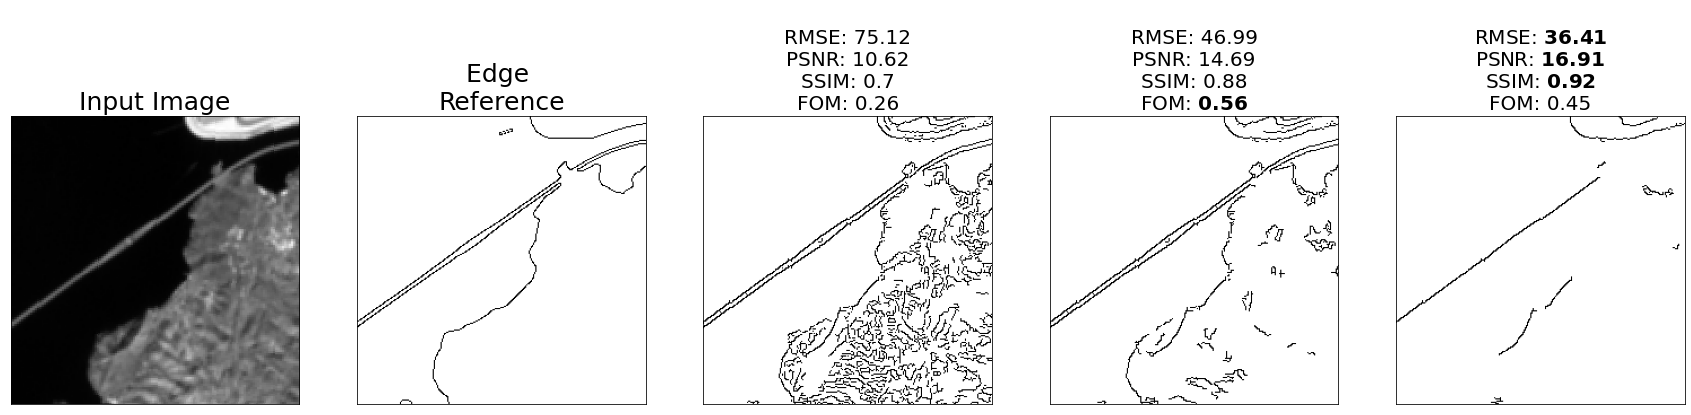

In [24]:
fig, axs = plt.subplots(1, 5, figsize=(30, 20))
fig.set_facecolor('white')
rint = np.random.randint(0, len(input))
#rint = 67

thresholds = [[50,100],[100,200],[200,400]]

band = 10 

img_input = input[rint].copy()
img_input = preprocess(img_input,[False,False,False])

axs[0].imshow(img_input[:,:,band],cmap="gray")
axs[0].set_title("Input Image",size=25)

ref_img = edge_reference[rint]
axs[1].imshow(255-ref_img,cmap="gray")
axs[1].set_title("Edge \nReference",size=25)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

for i,threshold in enumerate(thresholds):
        
    t1 = threshold[0]
    t2 = threshold[1]
    canny = utils.canny_ed(img_input,threshold1=t1,threshold2=t2)
    img = canny[:,:,band]
    
    axs[i+2].imshow(255-img,cmap="gray")
    rmse_ = round(rmse(ref_img,img),2)
    psnr_ = round(psnr(ref_img,img),2)
    ssim_ = round(ssim(ref_img,img,multichannel=True),2)
    fom_ = round(utils.fom(ref_img,img),2)

    if i == 0:
        axs[i+2].set_title("\nRMSE: {}\nPSNR: {}\nSSIM: {}\nFOM: {}".format(rmse_,psnr_,ssim_,fom_),size=20)
    elif i == 1:
        axs[i+2].set_title("\nRMSE: {}\nPSNR: {}\nSSIM: {}\nFOM: ".format(rmse_,psnr_,ssim_)+ r"$\bf{" + str(fom_) + "}$",size=20)
    else:
        axs[i+2].set_title("\nRMSE: " + r"$\bf{" + str(rmse_) + "}$" + 
        "\nPSNR: " + r"$\bf{" + str(psnr_) + "}$" +
        "\nSSIM: " + r"$\bf{" + str(ssim_) + "}$" +
        "\nFOM: " +str(fom_),size=20)
        

    

    #plt.savefig(fig_path.format("abstract.png"),bbox_inches="tight")    

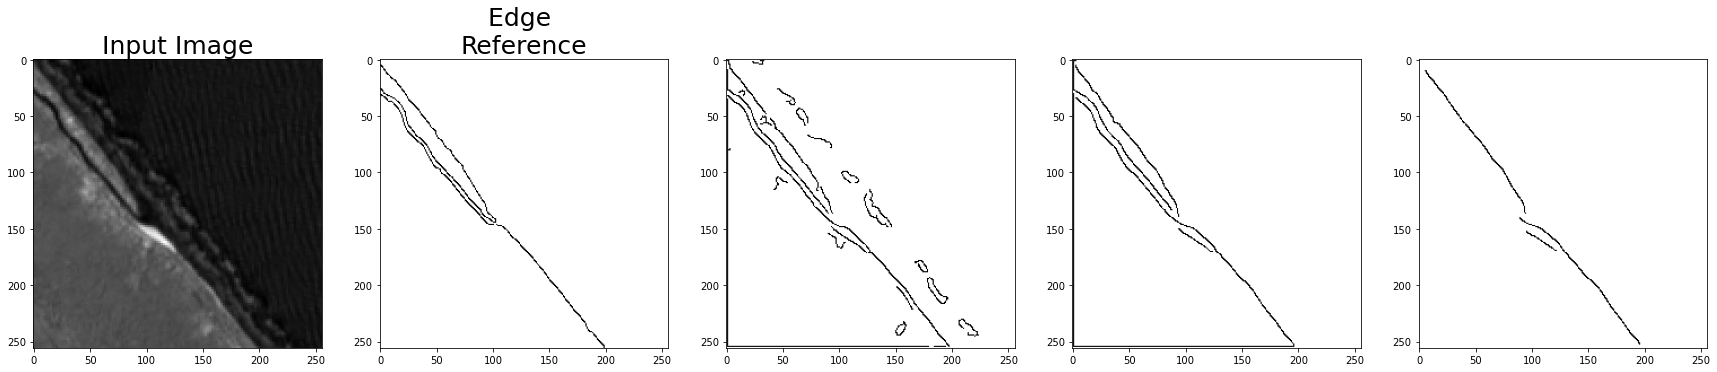

In [82]:
fig, axs = plt.subplots(1, 5, figsize=(30, 20))
fig.set_facecolor('white')

rint = 68
rint = np.random.randint(0, len(input))
band = 10 

img_input = input[rint].copy()
img_input = preprocess(img_input,[False,False,False])

axs[0].imshow(img_input[:,:,band],cmap="gray")
axs[0].set_title("Input Image",size=25)

ref_img = edge_reference[rint]
axs[1].imshow(255-ref_img,cmap="gray")
axs[1].set_title("Edge \nReference",size=25)

for i in [1,2,3]:
    canny = feature.canny(img_input[:,:,band], sigma=i, low_threshold=50, high_threshold=100)
    axs[i+1].imshow(255-canny,cmap="gray")